In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits

In [3]:
t11, t12, t22 = hp.read_map("../outputs/out_2MASS_XSC_EQ/tidal_sm1.0.fits", field=[2,3,4])
npix = len(t11)
nside = hp.get_nside(t11)

# generate eigenvectors
array_stack = np.zeros( (npix, 2, 2) ) # long axis is first
array_stack[:,0,0] = t11
array_stack[:,1,0] = t12
array_stack[:,0,1] = t12
array_stack[:,1,1] = t22
w,v = np.linalg.eig(a=array_stack)
principal_eig_ind = np.argmax( np.abs(w), axis=1 )
principal_eigenvectors = np.array( [v[i,:,principal_eig_ind[i]] for i in range(npix)] )
principal_eigenvalues = np.array( [w[i,principal_eig_ind[i]] for i in range(npix)] )

# load in galaxy
hdu = fits.open("../data/2MASS_XSC.fits")
galaxy_data = hdu[1].data

# masking and cuts
galaxy_ind = hp.ang2pix( 
    nside=nside, 
    phi=galaxy_data['dec'], theta=galaxy_data['ra'], lonlat=True )
mask = hp.read_map("../outputs/out_2MASS_XSC_EQ/mask.fits")
ellip = (1-galaxy_data['j_ba'])
cut = np.logical_and(galaxy_data['kcorr_schlegel'] < 13.9, mask[galaxy_ind] > 0.0)
cut = np.logical_and(cut, ellip > 0.5)
galaxy_data = galaxy_data[ cut ]

# get info
amp = 1#(1-galaxy_data['j_5sig_ba'])
phi_x = -amp * np.cos((90-galaxy_data['j_phi']) * np.pi / 180)
phi_y = amp * np.sin((90-galaxy_data['j_phi']) * np.pi / 180)
hp_gal = hp.ang2pix( 
    nside=nside, 
    phi=galaxy_data['dec'], theta=galaxy_data['ra'], lonlat=True )

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


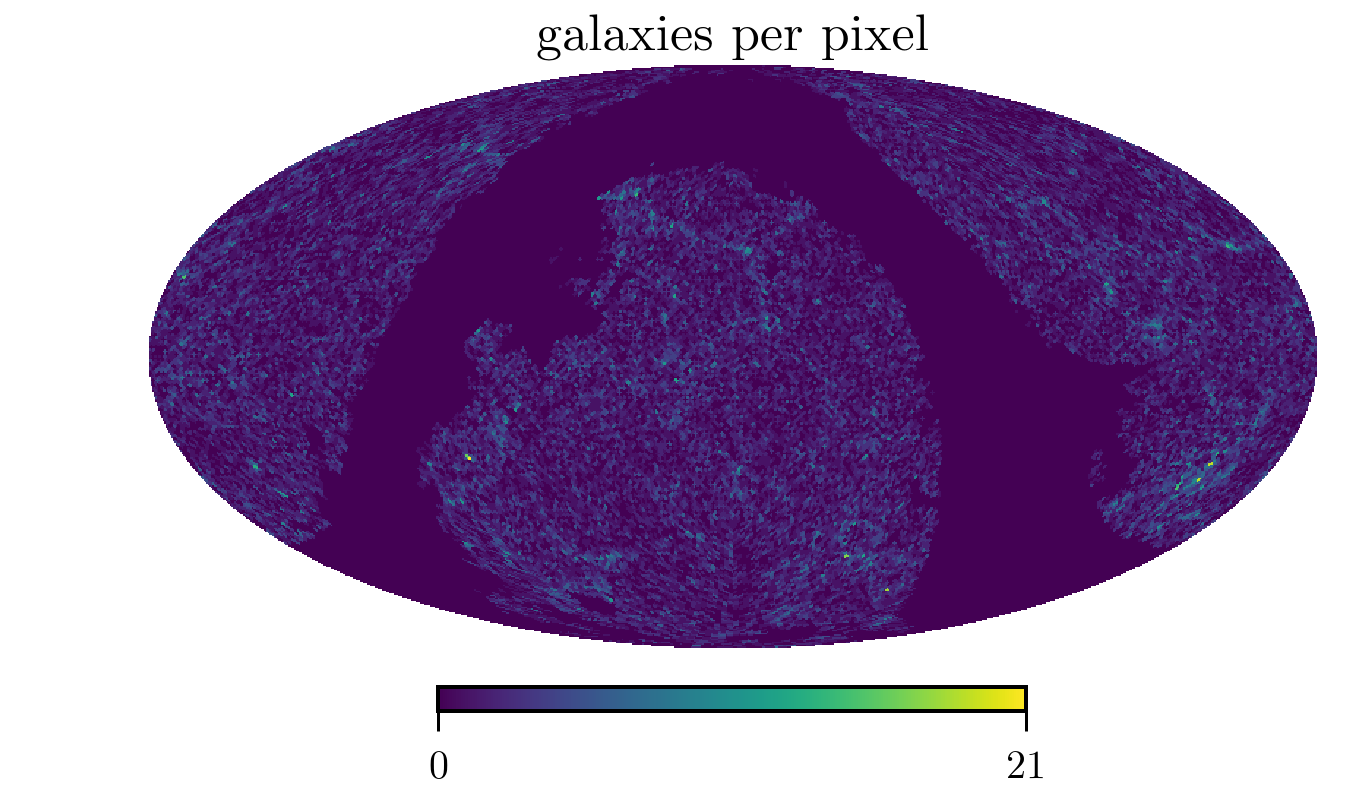

In [30]:
# check we are getting density right
counts_per_pixel = np.zeros(npix)
np.add.at(counts_per_pixel, hp_gal, 1)
hp.mollview(counts_per_pixel, title='galaxies per pixel')

/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


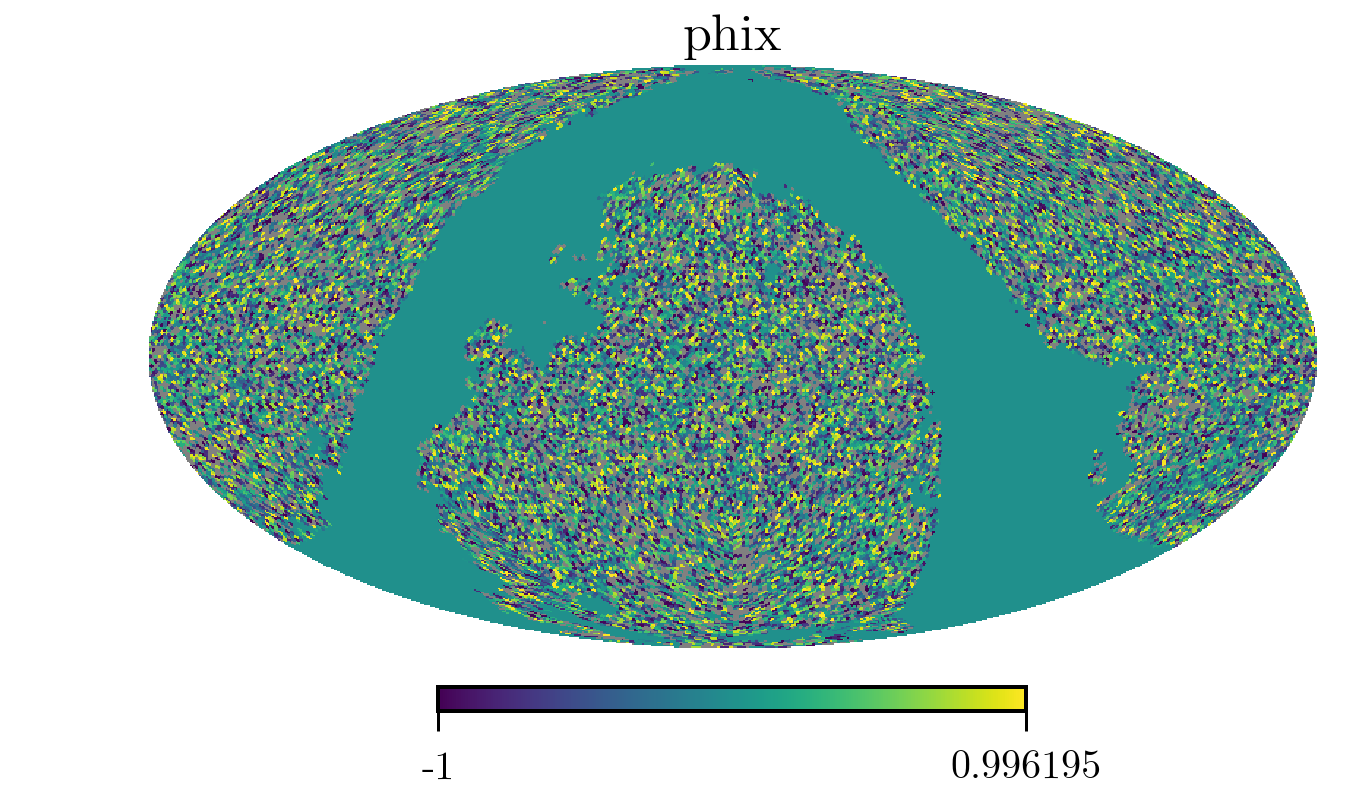

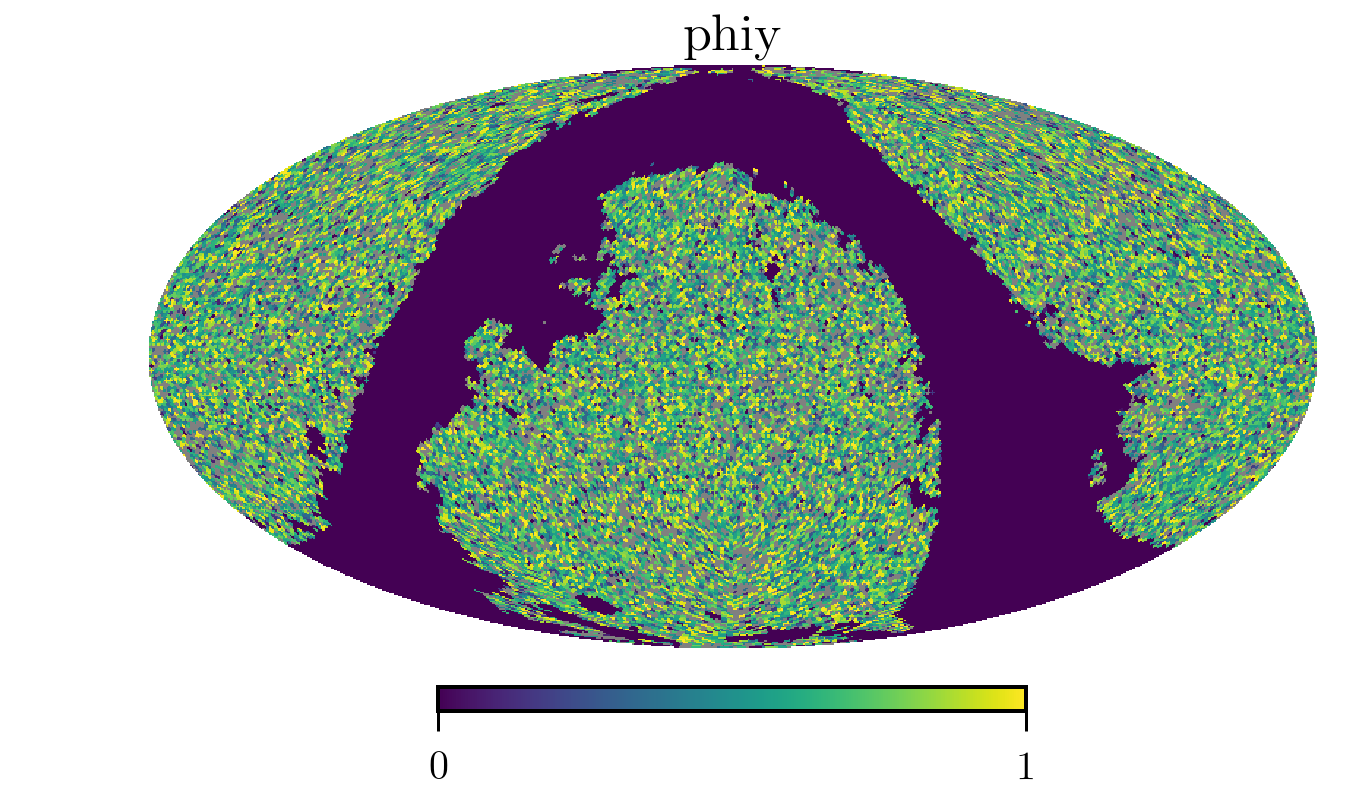

In [40]:
# check we are getting density right
binned_phi_x = np.zeros(npix)
binned_phi_y = np.zeros(npix)
np.add.at(binned_phi_x, hp_gal, phi_x)
np.add.at(binned_phi_y, hp_gal, phi_y)

binned_phi_x /= counts_per_pixel
binned_phi_y /= counts_per_pixel


binned_phi_x[ mask == 0.0 ] = 0
binned_phi_y[ mask == 0.0 ] = 0

hp.mollview(binned_phi_x, title='phix')
hp.mollview(binned_phi_y, title='phiy')

# By Pixel

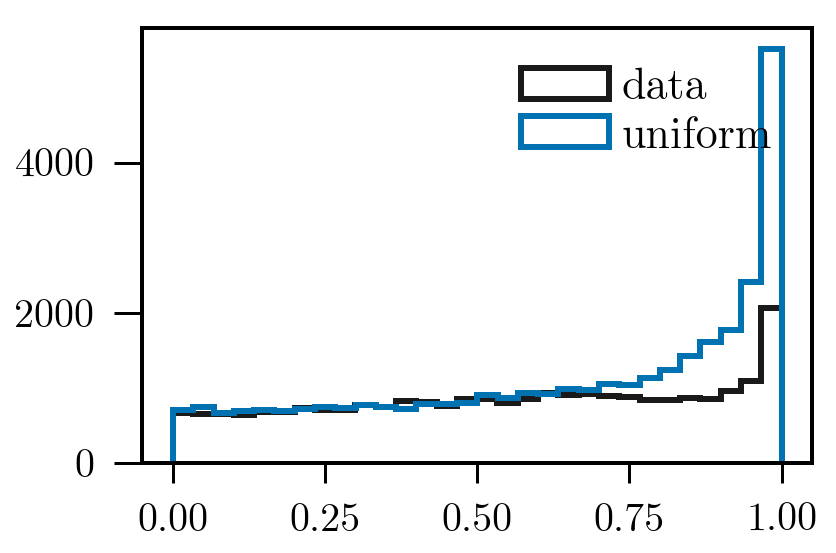

In [62]:
pix_dot = np.abs(binned_phi_x * principal_eigenvectors[:,0] + \
    binned_phi_y * principal_eigenvectors[:,1])

rand_theta = np.random.rand(npix) * 2 * np.pi
rand_x = np.cos(rand_theta)
rand_y = (np.sin(rand_theta))
rand_dot = np.abs(rand_x * principal_eigenvectors[:,0] + \
    rand_y * principal_eigenvectors[:,1])

plt.hist(pix_dot[mask > 0.0], bins=30, histtype="step", label="data")
plt.hist(rand_dot[mask > 0.0], bins=30, histtype="step", label="uniform")

plt.legend()

/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


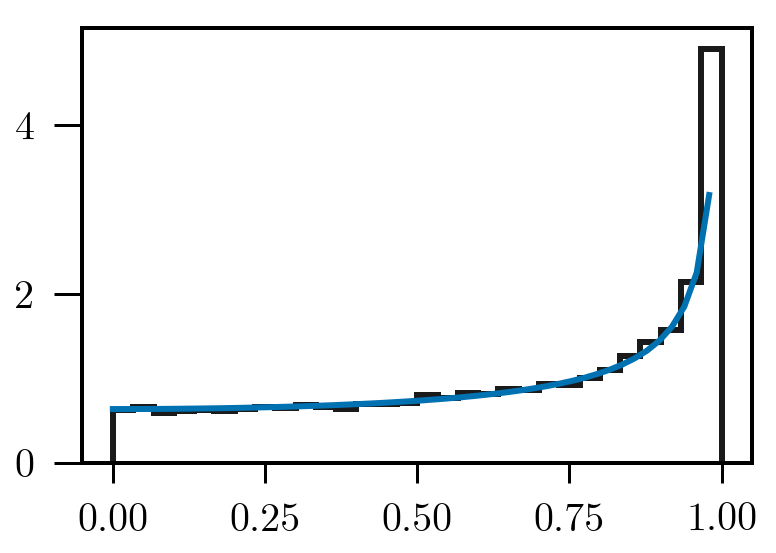

In [71]:

plt.hist(rand_dot[mask > 0.0], bins=30, histtype="step", label="uniform", normed=True)
xx = np.linspace(0,1.0)
plt.plot( xx, 2 / np.sqrt(1 - xx**2) / np.pi )

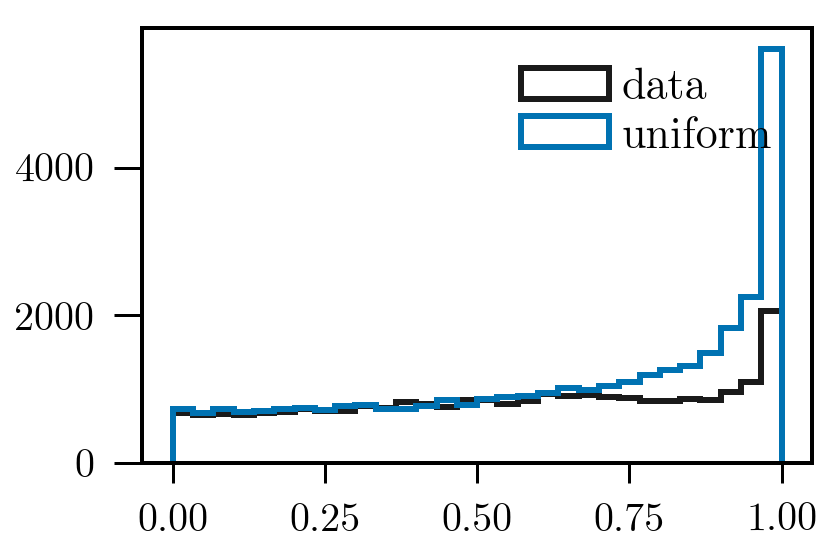

In [73]:
pix_dot = np.abs(binned_phi_x * principal_eigenvectors[:,0] + \
    binned_phi_y * principal_eigenvectors[:,1])

rand_theta = np.random.rand(npix) * 2 * np.pi
rand_x = np.cos(rand_theta)
rand_y = (np.sin(rand_theta))
rand_dot = np.abs(rand_x * principal_eigenvectors[:,0] + \
    rand_y * principal_eigenvectors[:,1])

plt.hist(pix_dot[mask > 0.0], bins=30, histtype="step", label="data")
plt.hist(rand_dot[mask > 0.0], bins=30, histtype="step", label="uniform")

plt.legend()

# By Galaxies

In [32]:
ngal = len(galaxy_data)
rand_theta = np.random.rand( ngal ) * 180 - 90
rand_phi_x = -np.cos((90-rand_theta) * np.pi / 180)
rand_phi_y = np.sin((90-rand_theta) * np.pi / 180)

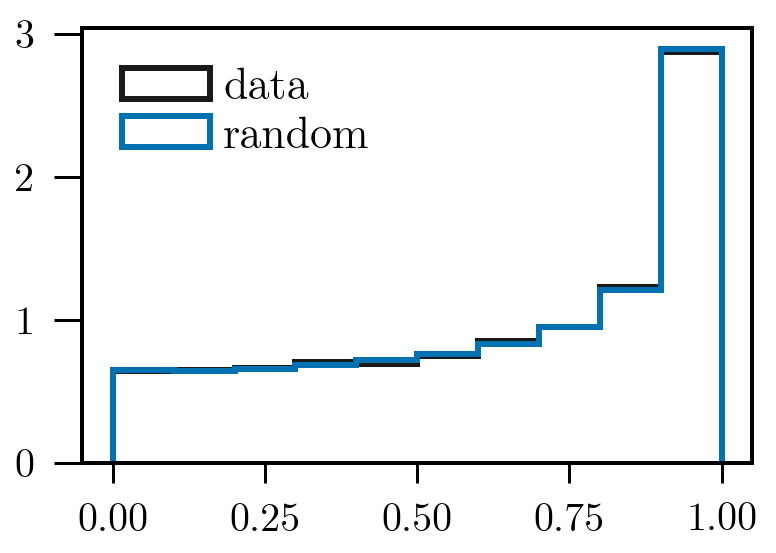

In [35]:
galaxy_tidal_x = principal_eigenvectors[hp_gal,0]
galaxy_tidal_y = principal_eigenvectors[hp_gal,1]
galaxy_tidal_lam = principal_eigenvalues[hp_gal]

abs_dot = np.abs(galaxy_tidal_x * phi_x + galaxy_tidal_y * phi_y)
rand_dot = np.abs(galaxy_tidal_x * rand_phi_x + galaxy_tidal_y * rand_phi_y)
# plt.hist( abs_dot );
countsg, bins, _ = plt.hist( abs_dot, histtype="step", label="data", normed=True );
countsr, bins, _ = plt.hist( rand_dot, histtype="step", label="random", normed=True );
plt.legend(loc="upper left")

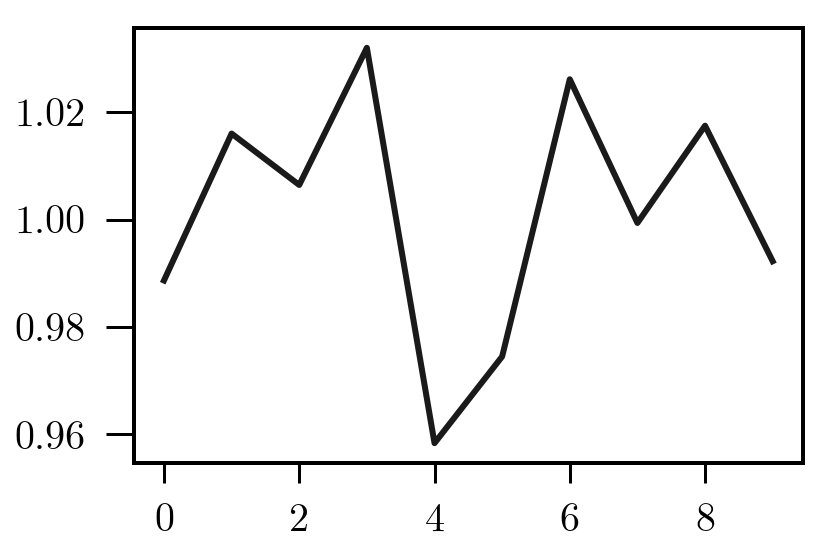

In [36]:
plt.plot( countsg / countsr )

In [8]:
# phi_x_pixel = np.zeros(npix)
# phi_y_pixel = np.zeros(npix)
# counts_per_pixel = np.zeros(npix)

# np.add.at(counts_per_pixel, galaxy_ind, 1)
# np.add.at(phi_x_pixel, galaxy_ind, phi_x)
# np.add.at(phi_y_pixel, galaxy_ind, phi_y)

# phi_x_pixel /= counts_per_pixel
# phi_y_pixel /= counts_per_pixel
# phi_x_pixel[counts_per_pixel == 0] = np.nan
# phi_y_pixel[counts_per_pixel == 0] = np.nan

# hp.mollview(counts_per_pixel, title="galaxy number counts")
# hp.mollview(phi_x_pixel * mask, title="binned phi_x")
# hp.mollview(phi_y_pixel * mask, title="binned phi_y")

In [9]:
# result_dot = np.abs(phi_x_pixel * principal_eigenvectors[:,0] + phi_y_pixel * principal_eigenvectors[:,1])
# random_dot = np.abs(phi_x_pixel_u * principal_eigenvectors[:,0] + phi_y_pixel_u * principal_eigenvectors[:,1])

# plt.hist( (result_dot)[mask > 0], bins=10, histtype="step", label=r"$\vec{t} \cdot \vec{e}_0$", normed=True );
# plt.hist( (random_dot)[mask > 0], bins=10, histtype="step", label=r"$\vec{t} \cdot \vec{u}$", normed=True );
# # plt.xlim(0,0.3)
# plt.legend()